In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score


In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

!wget $data

--2022-10-03 10:34:03--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘WA_Fn-UseC_-Telco-Customer-Churn.csv’

WA_Fn-UseC_-Telco-C 100%[===================>] 954.59K  2.07MB/s    in 0.5s    

2022-10-03 10:34:04 (2.07 MB/s) - ‘WA_Fn-UseC_-Telco-Customer-Churn.csv’ saved [977501/977501]



### classification model

In [4]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### EDA - Data Prep

In [5]:
df.columns = df.columns.str.lower().str.replace(' ','_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ','_')


df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [6]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

df.churn.head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

### training & testing data

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

### feature engineering - one-hot encoding

In [8]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [9]:
dv  = DictVectorizer(sparse=False)

train_dict = df_train[numerical + categorical].to_dict(orient='records')

X_train = dv.fit_transform(train_dict)

### Model - Logistic Regression 

In [10]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### Validation of model

In [20]:
val_dict = df_val[numerical + categorical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_val_pred = model.predict_proba(X_val)[:,1]
churn_pred = (y_val_pred >= 0.5)

accuracy = round((y_val == churn_pred).mean(), 4)
accuracy

0.8034

In [35]:
accuracy_score(y_val, churn_pred)

0.8034066713981547

### Accuracy & Dummy Model

In [14]:
f'Total saples in validation data : {len(y_val)}'

'Total saples in validation data : 1409'

In [15]:
f'correct prediction : {(y_val == churn_pred).sum()}'

'correct prediction : 1132'

In [16]:
f'accuracy : {1132/1409}'

'accuracy : 0.8034066713981547'

In [17]:
## we have decided a threshold of 0.5 to calculate the prediction
thresholds = np.linspace(0,1,21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [32]:
scores = []
print('Thres : Accu')
for t in thresholds:
    ite_churn_pred = (y_val_pred >= t)
    #score = (y_val == ite_churn_pred).mean()
    score = accuracy_score(y_val, ite_churn_pred)
    print('%.2f : %.3f' % (t,score))
    scores.append(score)

Thres : Accu
0.00 : 0.274
0.05 : 0.509
0.10 : 0.591
0.15 : 0.666
0.20 : 0.710
0.25 : 0.739
0.30 : 0.760
0.35 : 0.772
0.40 : 0.785
0.45 : 0.793
0.50 : 0.803
0.55 : 0.801
0.60 : 0.795
0.65 : 0.786
0.70 : 0.766
0.75 : 0.744
0.80 : 0.735
0.85 : 0.726
0.90 : 0.726
0.95 : 0.726
1.00 : 0.726


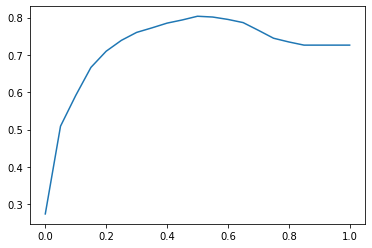

In [33]:
plt.plot(thresholds, scores)

In [37]:
from collections import Counter
Counter(y_val_pred >= 1.0)



Counter({False: 1409})

In [39]:
y_val.mean(), 1 - y_val.mean()

(0.2739531582682754, 0.7260468417317246)

In [40]:
#class imbalance - where majority of the input data set is non - churner : 73% 
# so we can have a dummy model with threshold 1.0 which predicts every one to be non-churner. As it turns out, this model is 73% accurate.
# even though we got good accuracy, that's not becuase of good prediction but because of class imbalance.

#### confusion table

In [41]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [46]:
t = 0.5

predict_positive = (y_val_pred >= t)
predict_negative = (y_val_pred < t)

In [48]:
tru_pos = (predict_positive & actual_positive).sum()
tru_neg = (predict_negative & actual_negative).sum()

tru_pos, tru_neg

(210, 922)

In [49]:
fal_pos = (predict_positive & actual_negative).sum()
fal_neg =  (predict_negative & actual_positive).sum()

fal_pos, fal_neg

(101, 176)

In [50]:
a1 = np.array([
    [6,8],
    [4,8]
])

In [55]:
a2 = np.array([
    [3,2],
    [4,4]
])

In [56]:
a1/a2

array([[2. , 4. ],
       [0.5, 2. ]])

In [58]:
a2 + a1

array([[ 9, 10],
       [ 6, 12]])

In [59]:
confusion_matrix = np.array([
    [tru_neg, fal_pos],
    [fal_neg, tru_pos]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

In [60]:
confusion_matrix.sum()

1409

In [62]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

#### Precision & Recall

* precision - fraction of positive prediction which is correct
* precision, $P = TP/(TP + FP)$
    * TP - True Positive
    * FP - False Positive

</br>

* recall - fraction of positive outcomes which is predicted correctly
* recall - $r = TP/(TP + FN)$
    * TP - True Positive
    * FN - False Negative

In [63]:
(tru_pos + tru_neg) / (tru_pos + fal_pos + tru_neg + fal_neg)

0.8034066713981547

In [64]:
precison = tru_pos / (tru_pos + fal_pos)
precison

0.6752411575562701

In [65]:
recall = tru_pos / (tru_pos + fal_neg)
recall

0.5440414507772021

#### ROC - Curves

* ROC - Receiver Operating Characteristics

* False Positive Rate, $FPR = FP / (FP + TN)$
* True Positive Rate = Recall, $TPR = TP / (TP + FN)$ 

* The higher the TPR, the better the model
* The lower the FPR, the better the model

In [66]:
tpr = tru_pos / (tru_pos + fal_neg)
tpr

0.5440414507772021

In [67]:
fpr = fal_pos / (fal_pos + tru_neg)
fpr

0.09872922776148582

In [68]:
scores = []

thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_val_pred >= t)
    predict_negative = (y_val_pred < t)

    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()

    fp = (actual_negative & predict_positive).sum()
    fn = (actual_positive & predict_negative).sum()

    scores.append((t,tp,fp,fn,tn))



In [71]:
columns = ['threshold', 'tp','fp','fn','tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,76,20,310,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [73]:
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores[::10]

,threshold,tp,fp,fn,tn,fpr,tpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.543500,0.948187
20,0.2,333,356,53,667,0.347996,0.862694
30,0.3,284,236,102,787,0.230694,0.735751
40,0.4,249,166,137,857,0.162268,0.645078
50,0.5,210,101,176,922,0.098729,0.544041
60,0.6,150,53,236,970,0.051808,0.388601
70,0.7,76,20,310,1003,0.019550,0.196891
80,0.8,13,1,373,1022,0.000978,0.033679
90,0.9,0,0,386,1023,0.000000,0.000000


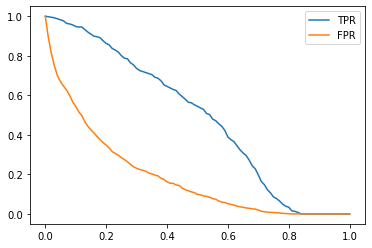

In [74]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()

#### Random Model
* randomly predicts churn or no churn

In [75]:
np.random.seed(1)
y_rand = np.random.uniform(0,1,len(y_val))

((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [78]:
def tpr_fpr_df(y_val, y_val_pred):
    scores = []

    thresholds = np.linspace(0,1,101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_val_pred >= t)
        predict_negative = (y_val_pred < t)

        tp = (actual_positive & predict_positive).sum()
        tn = (actual_negative & predict_negative).sum()

        fp = (actual_negative & predict_positive).sum()
        fn = (actual_positive & predict_negative).sum()

        scores.append((t,tp,fp,fn,tn))
        

    columns = ['threshold', 'tp','fp','fn','tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)

    return df_scores

    
    

In [79]:
df_rand_scores = tpr_fpr_df(y_val, y_rand)
df_rand_scores[::10]

,threshold,tp,fp,fn,tn,fpr,tpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.902248,0.898964
20,0.2,307,822,79,201,0.803519,0.795337
30,0.3,276,724,110,299,0.707722,0.715026
40,0.4,237,624,149,399,0.609971,0.613990
50,0.5,202,518,184,505,0.506354,0.523316
60,0.6,161,409,225,614,0.399804,0.417098
70,0.7,121,302,265,721,0.295210,0.313472
80,0.8,78,206,308,817,0.201369,0.202073
90,0.9,40,101,346,922,0.098729,0.103627


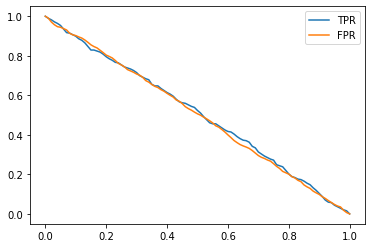

In [80]:
plt.plot(df_rand_scores.threshold, df_rand_scores.tpr, label='TPR')
plt.plot(df_rand_scores.threshold, df_rand_scores.fpr, label='FPR')
plt.legend()

#### Ideal Model

* The model which predicts current churning for everyone - 100% accuracy

In [82]:
f'not chirning : {1-y_val.mean()}, churning : {y_val.mean()}'

'not chirning : 0.7260468417317246, churning : 0.2739531582682754'

In [83]:
#If the threshold of our model is set to 0.726, then our model will become 100 % accurate

In [84]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

num_neg, num_pos, num_pos/(num_neg + num_pos)

(1023, 386, 0.2739531582682754)

In [85]:
y_ideal = np.repeat([0,1],[num_neg,num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [87]:
y_ideal_pred = np.linspace(0,1,len(y_ideal))

((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [88]:
df_ideal_scores = tpr_fpr_df(y_ideal, y_ideal_pred)
df_ideal_scores[::10]

,threshold,tp,fp,fn,tn,fpr,tpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,0.862170,1.000000
20,0.2,386,741,0,282,0.724340,1.000000
30,0.3,386,600,0,423,0.586510,1.000000
40,0.4,386,459,0,564,0.448680,1.000000
50,0.5,386,319,0,704,0.311828,1.000000
60,0.6,386,178,0,845,0.173998,1.000000
70,0.7,386,37,0,986,0.036168,1.000000
80,0.8,282,0,104,1023,0.000000,0.730570
90,0.9,141,0,245,1023,0.000000,0.365285


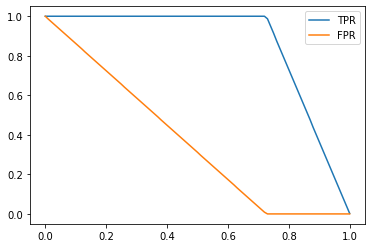

In [89]:
plt.plot(df_ideal_scores.threshold, df_ideal_scores.tpr, label='TPR')
plt.plot(df_ideal_scores.threshold, df_ideal_scores.fpr, label='FPR')
plt.legend()

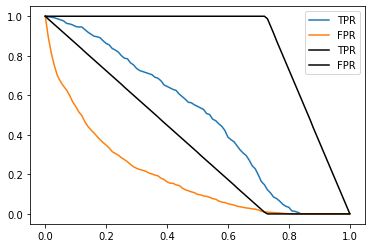

In [90]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.plot(df_ideal_scores.threshold, df_ideal_scores.tpr, label='TPR', color='black')
plt.plot(df_ideal_scores.threshold, df_ideal_scores.fpr, label='FPR', color='black')
plt.legend()

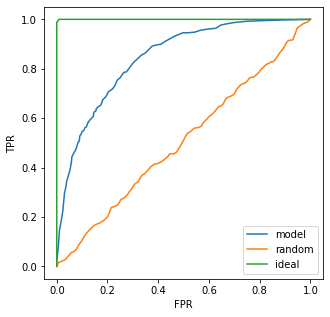

In [92]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand_scores.fpr, df_rand_scores.tpr, label='random')
plt.plot(df_ideal_scores.fpr, df_ideal_scores.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()


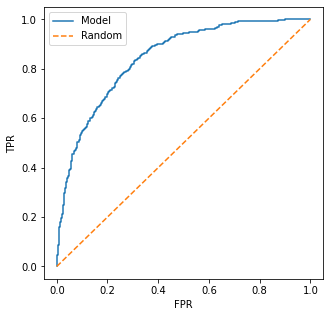

In [93]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

#### ROC - AUC
* area under the ROC curve
* the more the area, the better the model

In [94]:
from sklearn.metrics import auc

auc(fpr, tpr) #fpr & tpr that we got from sklearn for our model

0.843850505725819

In [95]:
auc(df_scores.fpr, df_scores.tpr) # our own calculated fpr, tpr for our model

0.8438732975754537

In [96]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_val_pred)

0.843850505725819

* AUC - Probability that randomly selected positive example(1) has higer score (pred probability - {0,1}) than randomly selected negative example (0)

In [97]:
neg = y_val_pred[y_val == 0]
pos = y_val_pred[y_val == 1]

In [100]:
import random

n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) -1)
    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.84474

In [101]:
n = 50000

pos_ind = np.random.randint(0,len(pos),size=n)
neg_ind = np.random.randint(0,len(neg),size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84486

#### cross validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [102]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [103]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [104]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

In [105]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.840 +- 0.007
C=1 0.841 +- 0.008
C=5 0.840 +- 0.008
C=10 0.841 +- 0.008


In [107]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259